# Milestone 2: Project proposal and initial analysis

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>Project:</strong> Decoding Box-Office Bombs 💣
    <br>
    <strong>Team:</strong> ADAdventurers2024
</div>

To replicate our dataset, please download the data indicated in the [README](https://github.com/epfl-ada/ada-2024-project-adaventurers2024/blob/main/README.md) file. Then, navigate to the `scripts` folder and run the following script:

```cmd
python preprocess_data.py
```

This script will generate five files in the data folder:

- `cmu_tmdb.csv`: A merged dataset from CMU and TMDB, containing movie information such as revenue, budget, and other details.
- `movie_tropes.csv`: Tropes associated with each movie in the IMDb dataset, which serves as an intermediary file for merging tropes with the CMU dataset.
- `cmu_tropes.csv`: Tropes associated with each movie in the CMU dataset.
- `movie_actors.csv`: Actors linked to each movie in the CMU dataset.
- `movie_directors_actors.csv`: Directors and actors linked to each movie in the IMDb dataset.

You can now proceed with exploratory data analysis and initial assessments.

------

## Exploratory data analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "data"

#### CMU revenue and other metrics

In [ ]:
df_cmu_tmdb = pd.read_csv(f"{DATA_PATH}/cmu_tmdb.csv")
df_cmu_tmdb.head()

In [ ]:
df_cmu_tmdb.info()

#### CMU cast and crew

In [ ]:
df_movie_actors = pd.read_csv(f"{DATA_PATH}/movie_actors.csv")
df_movie_actors.head()

In [ ]:
df_movie_actors.info()

#### CMU tropes

In [ ]:
df_cmu_tropes = pd.read_csv(f"{DATA_PATH}/cmu_tropes.csv")
df_cmu_tropes.head()

In [ ]:
df_cmu_tropes.info()

--------

## Research questions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import warnings

warnings.filterwarnings("ignore")

# Set visualization style
%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>📊 Metrics & Performance
</strong> 
</div>


#### 1. What metrics (e.g., low ratings, limited number of ratings, revenue vs budget) best indicate movie failure?


In [ ]:
# 1. Initialize

# Load the dataset
df = pd.read_csv("data/cmu_tmdb.csv")

# 2. Process the dataset

# Check 0 vote_average, revenue, and budget
print(
    f"Number of 0 values in each column: {(df[['vote_average', 'revenue', 'budget']] == 0).sum()}"
)
print(
    f"Number of missing values in each column: {df[['vote_average', 'revenue', 'budget']].isnull().sum()}"
)

# remove rows if one of vote_average, revenue, and budget is 0
df = df[(df[["vote_average", "revenue", "budget"]] != 0).all(axis=1)]
df.reset_index(drop=True, inplace=True)

# Calculate profit
df["profit"] = df["revenue"] - df["budget"]
# Calculate the ratio of revenue to budget
df["revenue_to_budget"] = df["revenue"] / df["budget"]

# Logscale the revenue and profit columns
df["log_revenue"] = np.log1p(df["revenue"])
df["log_profit"] = np.log1p(df["profit"])
df["log_revenue_to_budget"] = np.log1p(df["revenue_to_budget"])

# 3. Analysze

# 3.1 Initial statistical summary
print(df[["vote_average", "vote_count", "revenue", "profit"]].describe())

# 3.2 Distribution plots
variables = ["vote_average", "log_revenue", "log_profit", "log_revenue_to_budget"]
for var in variables:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[var], bins=20, kde=True)
    plt.title(f"Distribution of {var.capitalize()}")
    plt.xlabel(var.capitalize())
    plt.ylabel("Frequency")
    plt.show()

# 3.3 Scatter plot: Vote Average vs. Vote Count
plt.figure(figsize=(10, 6))
sns.scatterplot(x="vote_count", y="vote_average", data=df)
plt.title("Vote Average vs. Vote Count")
plt.xlabel("Vote Count")
plt.ylabel("Vote Average")
plt.show()

# 3.4 Scatter plot: Revenue vs. Budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x="budget", y="revenue", data=df)
plt.title("Revenue vs. Budget")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

# 3.5 Scatter plot: Profit vs. Budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x="budget", y="profit", data=df)
plt.title("Profit vs. Budget")
plt.xlabel("Budget")
plt.ylabel("Profit")
plt.show()

# 3.6 Scatter plot: Average Rating vs. Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x="vote_average", y="revenue", data=df, alpha=0.7)
plt.title("Average Rating vs. Revenue")
plt.xlabel("Average Rating")
plt.ylabel("Revenue")
plt.yscale("log")  # Optional: Apply log scale if revenue has a wide range
plt.show()

# 3.7 Correlation matrix
corr_columns = ["vote_average", "vote_count", "revenue", "budget", "profit"]
corr_matrix = df[corr_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>👥 Cast & Crew Analysis</strong> 
</div>


#### 2. How do actor demographics and lack of diversity impact audience disengagement and contribute to box office underperformance?

In [ ]:
# 1. Load the dataset
df_movie_actors = pd.read_csv("./data/movie_actors.csv")

# Display the first few rows
print("First few rows of the dataset:")
display(df_movie_actors.head())

# 2. Data cleaning

# 2.1 Remove duplicates
num_duplicates = df_movie_actors.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

# Remove duplicates
df_movie_actors.drop_duplicates(inplace=True)

# 2.2 Handle missing values
print("\nMissing values per column:")
missing_values = df_movie_actors.isnull().sum()
print(missing_values)

# Drop rows with missing critical data
df_movie_actors.dropna(
    subset=[
        "actor_gender",
        "actor_age_at_movie_release",
        "revenue",
        "average_rating",
        "num_votes",
    ],
    inplace=True,
)

# Reset index after dropping rows
df_movie_actors.reset_index(drop=True, inplace=True)

# 3. Ethnicity mapping

# Map 'actor_ethnicity_freebase_id' to ethnicity names
ethnicity_mapping_df = pd.read_csv(
    "./data/wikidata_ethnicities.csv"
)  # Ensure this file exists
# Create mapping dictionary
ethnicity_mapping = pd.Series(
    ethnicity_mapping_df["itemLabel"].values, index=ethnicity_mapping_df["freebase_id"]
).to_dict()
# Map ethnicity IDs to names
df_movie_actors["actor_ethnicity"] = df_movie_actors["actor_ethnicity_freebase_id"].map(
    ethnicity_mapping
)

# Check for missing ethnicity mappings
missing_ethnicities = df_movie_actors[df_movie_actors["actor_ethnicity"].isnull()][
    "actor_ethnicity_freebase_id"
].unique()
print("\nMissing ethnicity mappings:", missing_ethnicities)

# 4. Data exploration

# 4.1 Overview of actor demographics
# Gender distribution
gender_counts = df_movie_actors["actor_gender"].value_counts()
print("\nGender distribution of actors:")
print(gender_counts)

# Plot gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="actor_gender", data=df_movie_actors)
plt.title("Actor Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# 4.2 Age distribution of actors
# Histogram of actor ages at movie release
plt.figure(figsize=(8, 6))
sns.histplot(df_movie_actors["actor_age_at_movie_release"], bins=30, kde=True)
plt.title("Age Distribution of Actors at Movie Release")
plt.xlim(0, 100)
plt.xlabel("Age")
plt.ylabel("Number of Actors")
plt.show()

# 4.3 Ethnicity diversity
# Count unique ethnicities
num_ethnicities = df_movie_actors["actor_ethnicity"].nunique()
print(f"\nNumber of unique ethnicities: {num_ethnicities}")

# Display counts
ethnicity_counts = df_movie_actors["actor_ethnicity"].value_counts()
print("\nEthnicity distribution of actors:")
print(ethnicity_counts.head())
# Plot ethnicity distribution (top 10)
plt.figure(figsize=(12, 6))
sns.countplot(
    y="actor_ethnicity", data=df_movie_actors, order=ethnicity_counts.index[:10]
)
plt.title("Top 10 Actor Ethnicities")
plt.xlabel("Count")
plt.ylabel("Ethnicity")
plt.show()

# 5. Assessing diversity per movie

# Group data by movie
grouped = df_movie_actors.groupby("movie_name")


# 5.1 Compute diversity metrics
def compute_diversity_metrics(group):
    num_actors = group["actor_name"].nunique()
    num_male = (group["actor_gender"] == "M").sum()
    num_female = (group["actor_gender"] == "F").sum()
    gender_diversity = num_female / num_actors if num_actors else np.nan
    num_ethnicities = group["actor_ethnicity"].nunique()
    age_std = group["actor_age_at_movie_release"].std()
    revenue = group["revenue"].mean()
    average_rating = group["average_rating"].mean()
    num_votes = group["num_votes"].sum()
    return pd.Series(
        {
            "num_actors": num_actors,
            "num_male": num_male,
            "num_female": num_female,
            "gender_diversity": gender_diversity,
            "num_ethnicities": num_ethnicities,
            "age_std": age_std,
            "revenue": revenue,
            "average_rating": average_rating,
            "num_votes": num_votes,
        }
    )


# Apply the function to each movie group
movie_metrics = grouped.apply(compute_diversity_metrics).reset_index()

# Display the metrics
print("\nDiversity metrics for movies:")
display(movie_metrics.head())

# 6. Analyzing the impact on ratings and revenue

# 6.1 Correlation Analysis
# Select relevant columns for correlation
corr_columns = [
    "gender_diversity",
    "num_ethnicities",
    "age_std",
    "revenue",
    "average_rating",
]
corr_matrix = movie_metrics[corr_columns].corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(corr_matrix)

# 6.2 Visualize correlations
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

# 6.3 Scatter plots

# 6.3.1 Gender Diversity vs. Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x="gender_diversity", y="revenue", data=movie_metrics)
plt.title("Gender Diversity vs. Revenue")
plt.xlabel("Gender Diversity (Proportion of Female Actors)")
plt.ylabel("Revenue")
plt.show()

# 6.3.2 Gender Diversity vs. Average Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x="gender_diversity", y="average_rating", data=movie_metrics)
plt.title("Gender Diversity vs. Average Rating")
plt.xlabel("Gender Diversity (Proportion of Female Actors)")
plt.ylabel("Average Rating")
plt.show()

# 6.3.3 Ethnic Diversity vs. Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x="num_ethnicities", y="revenue", data=movie_metrics)
plt.title("Ethnic Diversity vs. Revenue")
plt.xlabel("Number of Unique Ethnicities")
plt.ylabel("Revenue")
plt.show()

# 6.3.4 Ethnic Diversity vs. Average Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x="num_ethnicities", y="average_rating", data=movie_metrics)
plt.title("Ethnic Diversity vs. Average Rating")
plt.xlabel("Number of Unique Ethnicities")
plt.ylabel("Average Rating")
plt.show()

# 6.3.5 Age Diversity vs. Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x="age_std", y="revenue", data=movie_metrics)
plt.title("Age Diversity (Std Dev) vs. Revenue")
plt.xlabel("Age Standard Deviation")
plt.ylabel("Revenue")
plt.show()

# 6.3.6 Age Diversity vs. Average Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x="age_std", y="average_rating", data=movie_metrics)
plt.title("Age Diversity (Std Dev) vs. Average Rating")
plt.xlabel("Age Standard Deviation")
plt.ylabel("Average Rating")
plt.show()

#### 3. Is thematic consistency in director filmographies a predictor of movie failure?

- Now that information about directors has been harvested, the next phase consists in investigating the correlation between genre participation proportion. This will help determine whether successful direction correlates with specific genre patterns.

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>🎬 Genre & Market Factors</strong> 
</div>

#### 4. How does genre choice influence a movie's failure, particularly in different cultural contexts?
   
We employed several analytical approaches to understand genre impact on movie failure. 

- First, we used violin plots with symmetric log scaling to visualize profit distribution across genres, capturing both the central tendency and spread of financial performance. 
- To understand cultural reception, we analyzed the relationship between ratings and popularity (measured by vote count) using scatter plots with logarithmic scaling for vote counts. 
- We tracked genre performance over time using 5-year moving averages to identify long-term trends in audience reception. 
- Finally, we calculated and compared genre-specific success and failure rates to identify which genres carry the highest risk of significant financial loss.

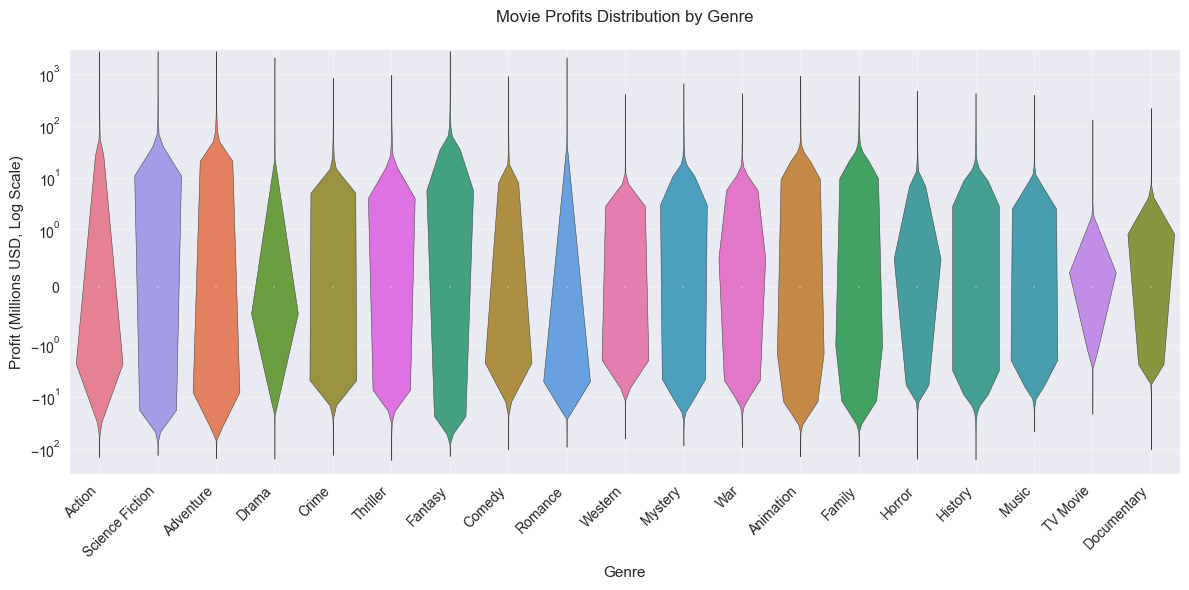

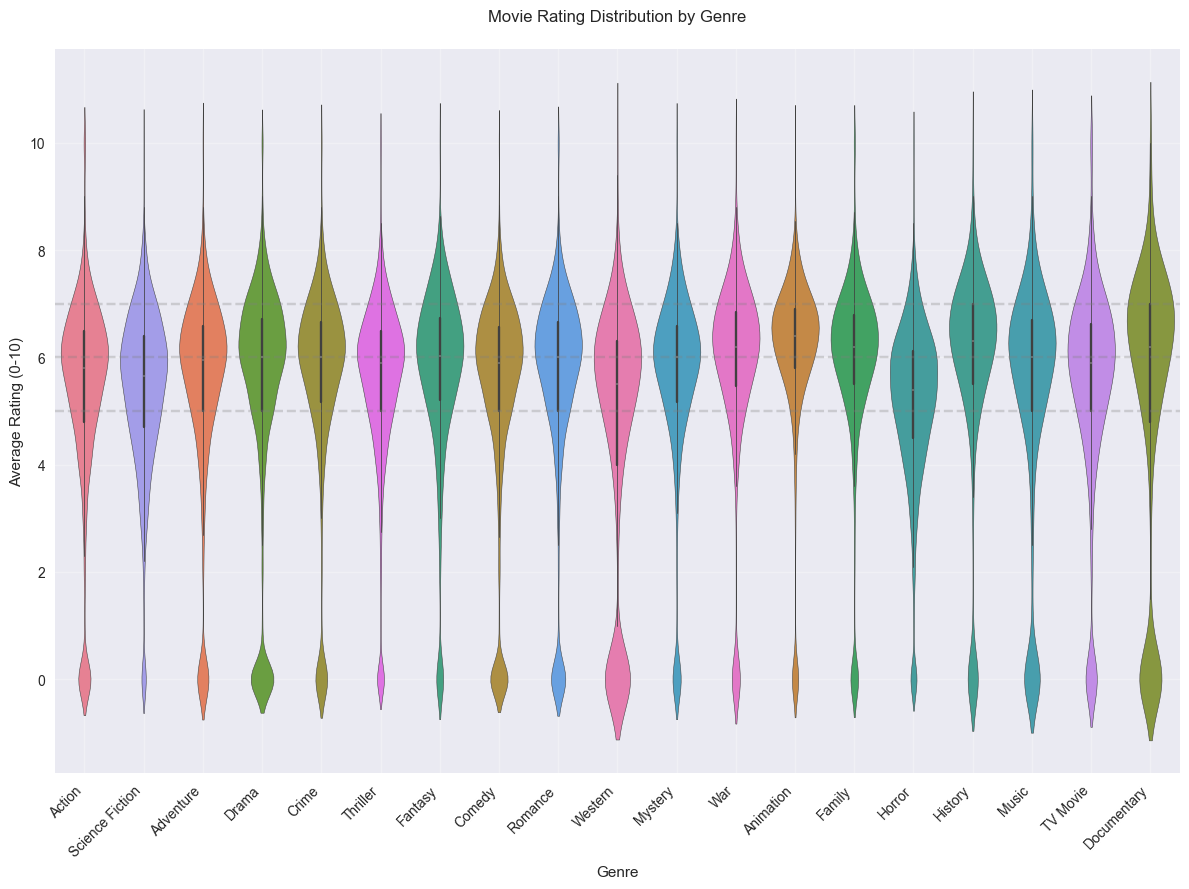

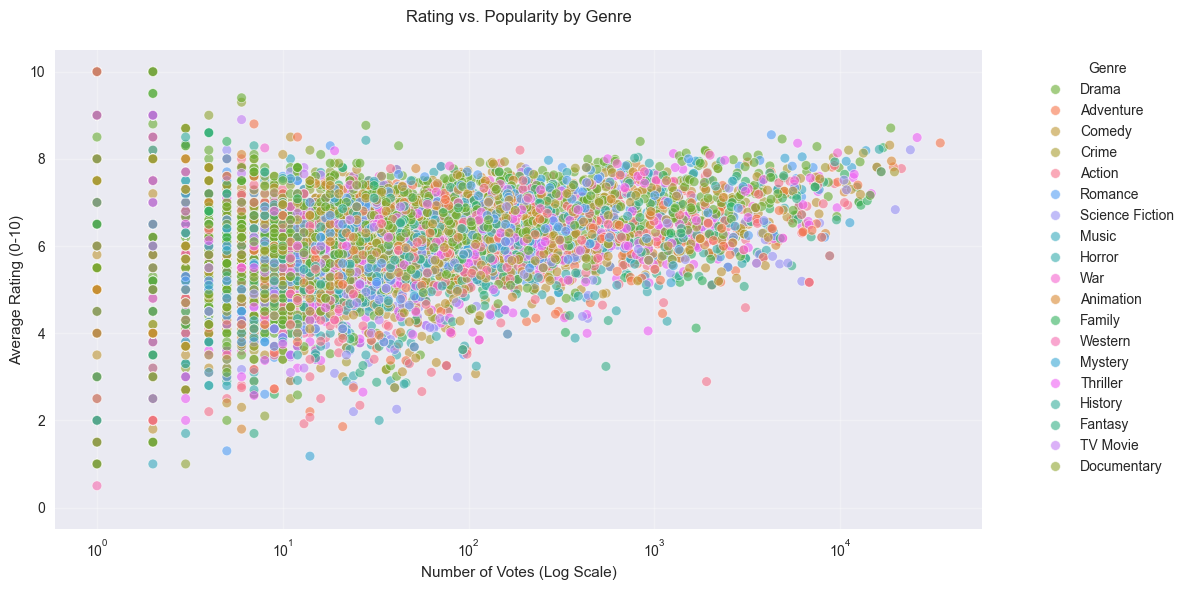

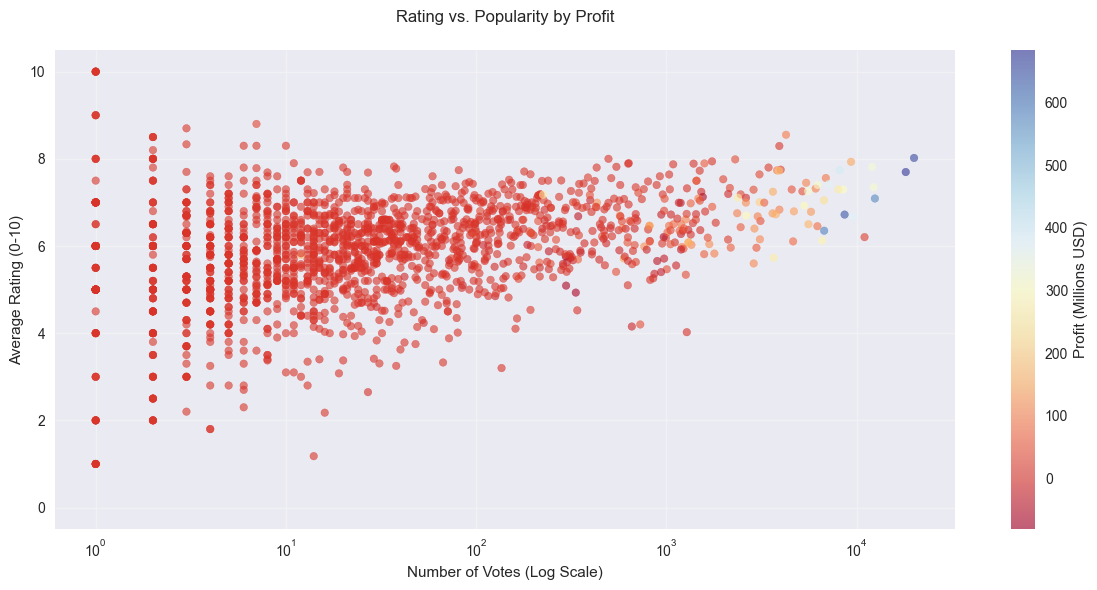

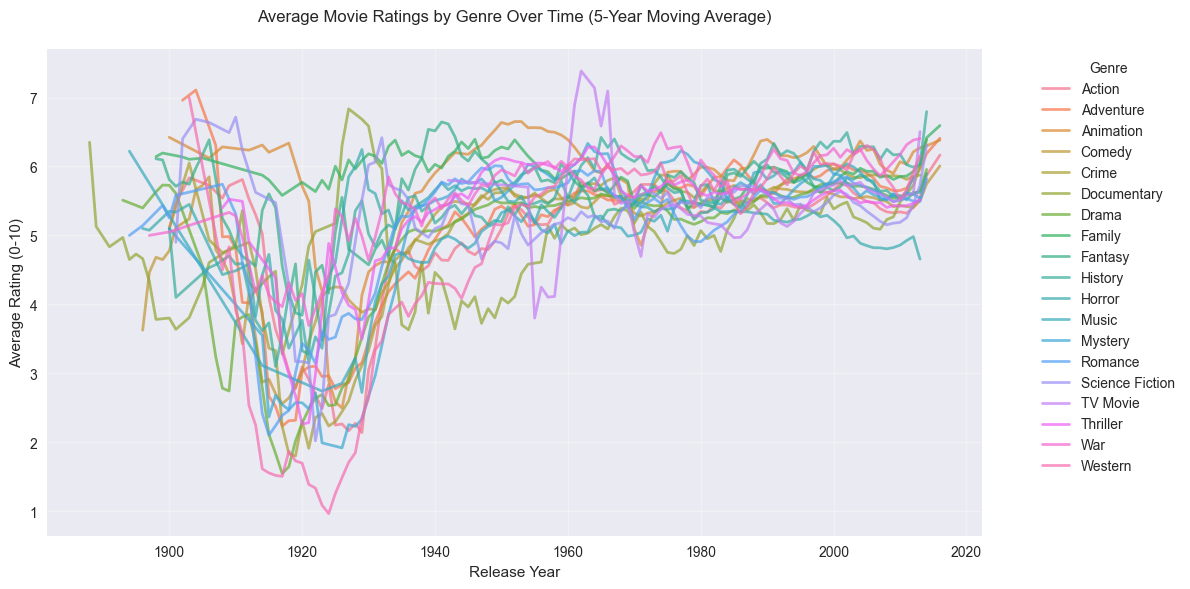


Overall ROI Statistics (cleaned):
count    5637.000000
mean        3.235608
std         7.884192
min        -0.989931
25%        -0.198579
50%         0.987574
75%         3.029376
max        50.000000
Name: roi_clean, dtype: float64


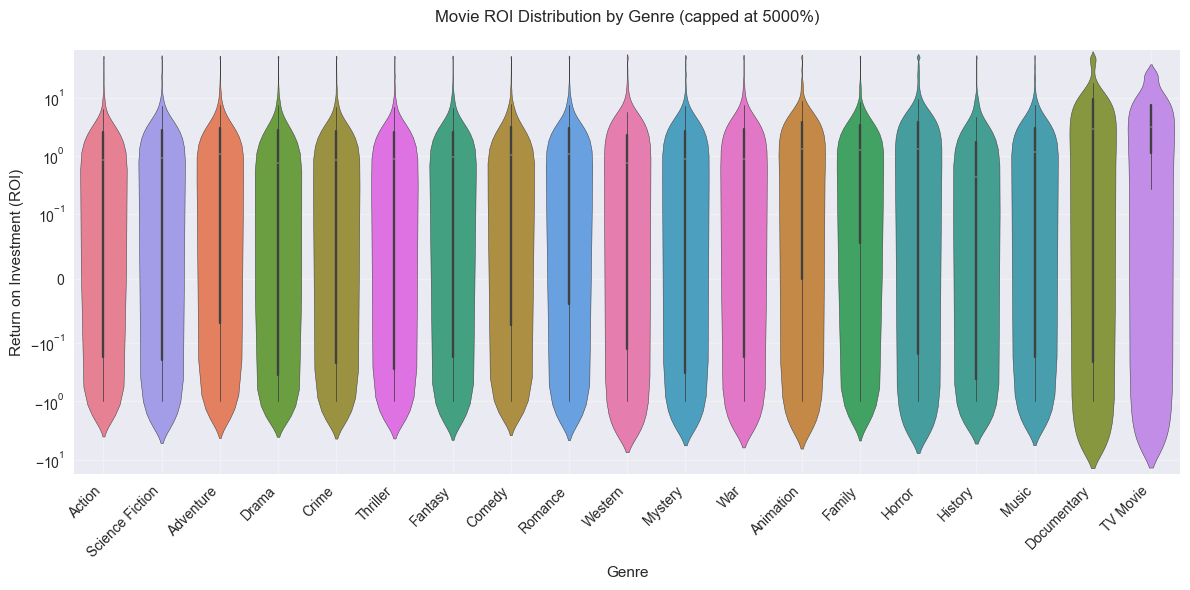


ROI Statistics by Budget Category (excluding zero budgets):
                roi_clean                     budget                     
                    count   mean median         mean       min        max
budget_category                                                          
Very Low              561  10.53   2.84    268873.33         1     840000
Low                   987   4.93   1.46   2223100.19    846000    4000000
Medium               1069   2.66   0.82   7346909.57   4015000   11000000
High                 1422   1.67   0.50  18571102.74  11300000   28000000
Very High            1598   1.41   0.87  65080901.05  29000000  379000000


/Users/rizhong/Documents/GitHub/ada-2024-project-adaventurers2024/src/scripts/genre_analysis.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  budget_roi = df_with_budget.groupby('budget_category').agg({


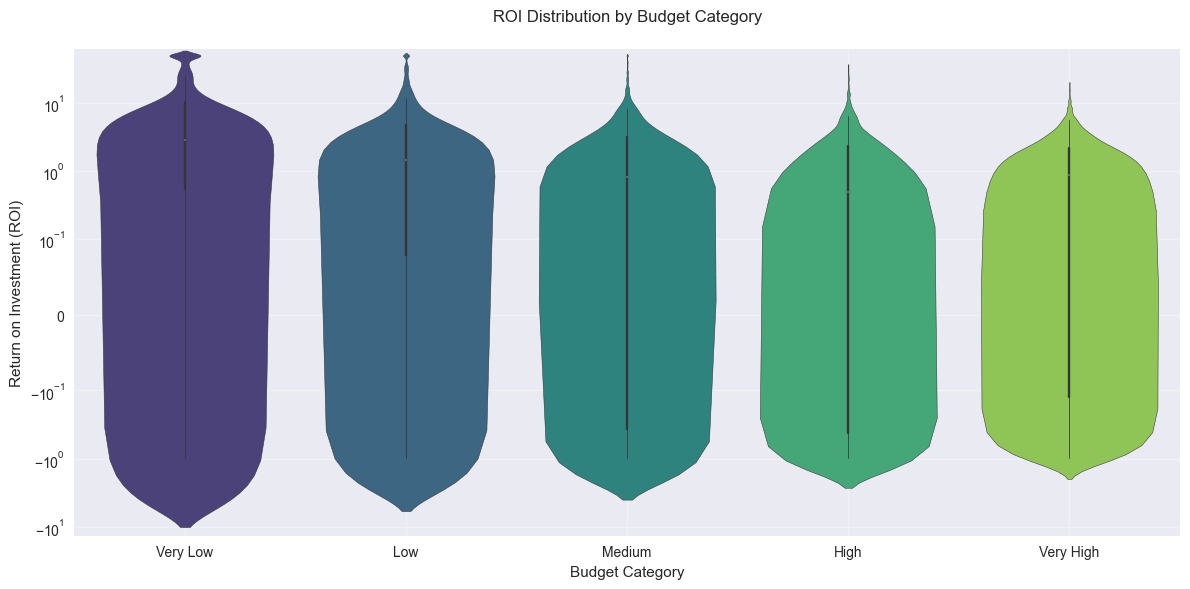


Performance Rates by Genre:
                 Total Loss (>90%)  Severe Loss (>70%)  \
Action                         0.7                 2.1   
Adventure                      0.6                 2.2   
Animation                      0.2                 0.9   
Comedy                         0.5                 1.3   
Crime                          0.8                 2.0   
Documentary                    0.2                 0.4   
Drama                          0.7                 1.6   
Family                         0.3                 1.0   
Fantasy                        0.6                 1.6   
History                        0.4                 2.5   
Horror                         0.8                 1.8   
Music                          0.5                 1.2   
Mystery                        1.0                 2.3   
Romance                        0.6                 1.4   
Science Fiction                1.0                 2.4   
TV Movie                       0.0         

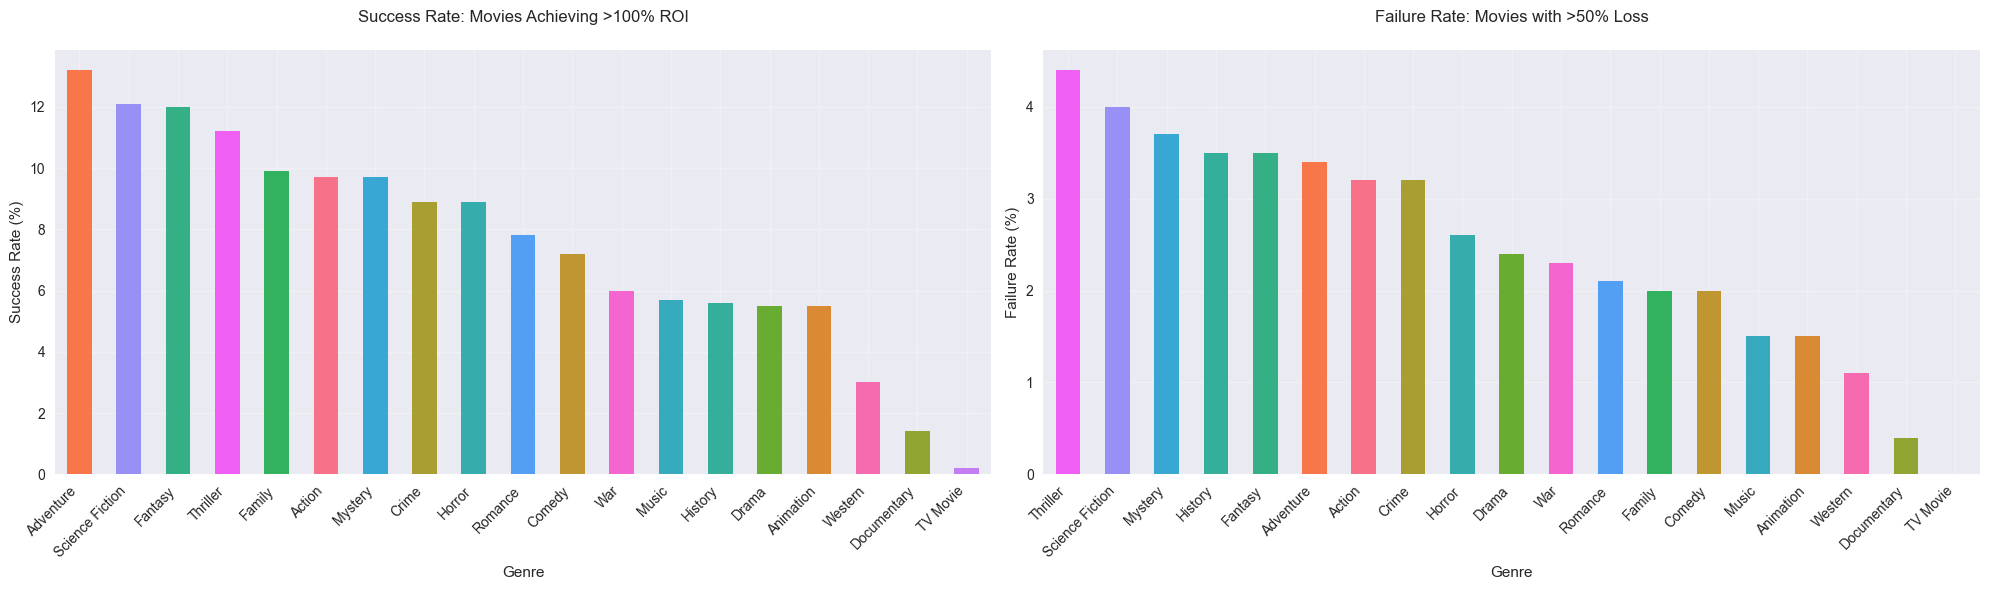


Summary Statistics by Genre:
                profit_scaled        vote_average        roi_clean       
                         mean median         mean  count      mean median
genres                                                                   
Action                  13.47    0.0         5.34   6410      2.45   0.85
Adventure               25.54    0.0         5.43   3656      2.83   1.10
Animation               13.08    0.0         6.01   2533      3.84   1.32
Comedy                   6.22    0.0         5.30  14528      2.85   1.06
Crime                    5.67    0.0         5.52   5059      2.61   0.85
Documentary              0.72    0.0         5.19   2535      9.03   2.94
Drama                    3.47    0.0         5.30  22560      2.94   0.76
Family                  15.86    0.0         5.85   3158      3.07   1.26
Fantasy                 23.92    0.0         5.70   2073      2.56   0.96
History                  3.79    0.0         5.78   1582      2.09   0.44
Horror  

In [1]:
from src.scripts.genre_analysis import *
from src.utils.visualization_utils import *

# Setup
setup_visualization()
df, df_genres = prepare_data("data/cmu_tmdb.csv")
unique_genres = sorted(df_genres["genres"].unique())
genre_colors = create_genre_colors(unique_genres)

# Basic Analysis
plot_genre_distributions(df_genres, genre_colors)

# Performance Analysis
plot_genre_performance(df_genres, genre_colors)

# Temporal Analysis
analyze_temporal_trends(df_genres, genre_colors, unique_genres)

# ROI Analysis
df, df_genres = analyze_roi(df, df_genres, genre_colors)

# Budget Analysis
budget_stats = analyze_budget_categories(df)

# Success/Failure Rate Analysis
performance_stats = analyze_success_failure_rates(
    df_genres, genre_colors, unique_genres
)

# Summary Statistics
summary_stats = get_summary_statistics(df_genres)

##### Financial Performance by Genre

1. High-Profit Potential:

- Action/Adventure/Fantasy lead in extreme profits (mean profits: 13-25M USD)
- Documentary/TV Movies show lowest profits but highest ROI (9.03 and 7.13)
- Horror shows strong ROI (5.69) with moderate investment
- Drama (most common genre, 22,560 movies) shows modest profits (3.47M USD)

2. Budget Impact:

- Very low budget films: Highest ROI potential but highest volatility
- High budget films: More consistent but lower returns
- Clear inverse relationship between budget size and ROI potential

##### Audience Reception

1. Ratings:

- Animation leads with highest average rating (6.01)
- Family/War films follow with strong ratings
- Western shows lowest ratings
- Most genres maintain 5-7 rating range
- Documentary shows most consistent ratings

2. Popularity Patterns:

- Popular movies (high vote counts) cluster around 6-7 ratings
- Less popular movies show wider rating variation
- Profitable movies typically have high vote counts
- Genre impact on popularity is minimal

##### Historical Trends

- Ratings stabilized post-1960
- High volatility in early years (pre-1940)
- Modern convergence around 5-6 rating range
- Genre distinctions decreased over time

##### Risk Assessment

1. Success Rates:

- Adventure/Science Fiction/Fantasy: Highest success rates
- Documentary/TV Movies: Extreme success/failure patterns
- Horror: Good success rate with moderate risk

2. Failure Rates:

- Thriller/Science Fiction/Mystery: Highest failure rates
- Action/Adventure: More moderate failure rates despite high budgets
- Documentary: High risk but high potential return

##### Key Takeaway

Genre significantly impacts financial performance and risk levels. While Action/Adventure/Fantasy lead in absolute profits, smaller genres like Documentary and Horror show strong ROI potential. Ratings remain relatively consistent across genres, with Animation and Family films maintaining slight advantages. Budget size shows stronger correlation with returns than genre choice.


#### 5. How does poor release timing (e.g., season, holiday periods) affect a movie's likelihood of failing?

- To investigate how release timing affects movie failure, we analyzed the distribution of profits and ratings across different temporal categories using violin plots. 
- We compared failure rates across seasons and months to identify particularly risky release periods. 
- To account for industry evolution, we examined the temporal trends of success and failure rates alongside movie release volume using a dual-axis visualization combining line graphs for rates and bar charts for release counts. 

This allowed us to identify historical patterns in optimal release timing while controlling for changes in industry output volume.

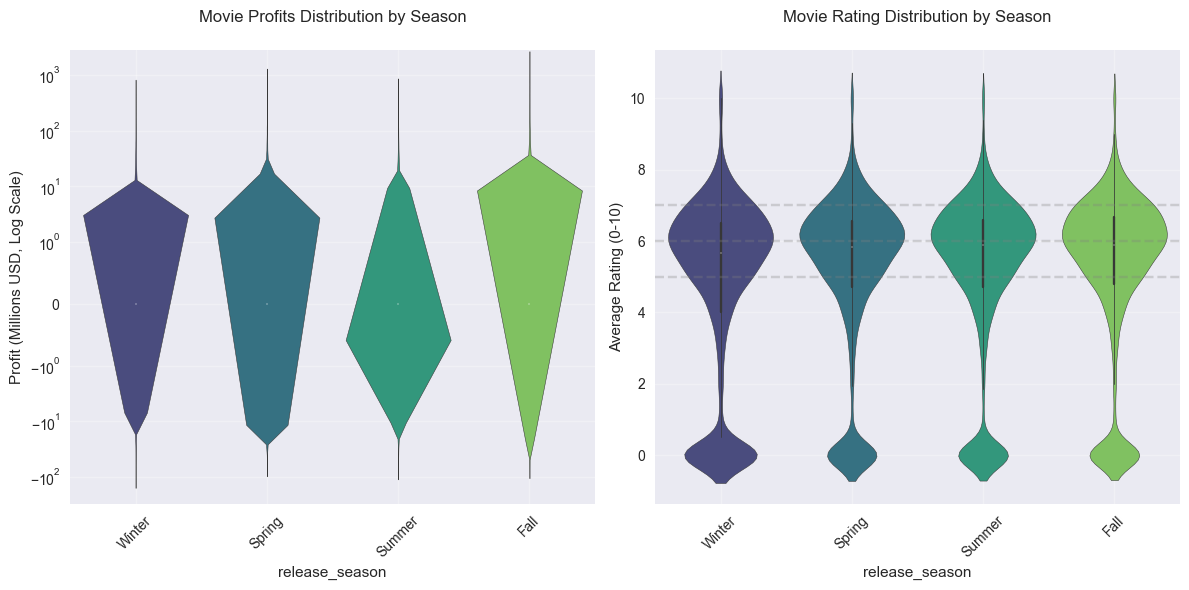

/Users/rizhong/Documents/GitHub/ada-2024-project-adaventurers2024/src/scripts/timing_analysis.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_stats = df.groupby('release_season').agg({
/Users/rizhong/Documents/GitHub/ada-2024-project-adaventurers2024/src/scripts/timing_analysis.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='release_month', y='profit_scaled',



Summary Statistics by Season:
               profit_scaled        vote_average        roi_clean       
                        mean median         mean  count      mean median
release_season                                                          
Winter                  2.56    0.0         4.72  13059      2.77   0.87
Spring                  7.23    0.0         5.10  11446      3.31   1.16
Summer                  4.33    0.0         5.13  11944      3.27   0.79
Fall                    5.93    0.0         5.19  13070      3.46   1.04


/Users/rizhong/Documents/GitHub/ada-2024-project-adaventurers2024/src/scripts/timing_analysis.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='release_month', y='vote_average',


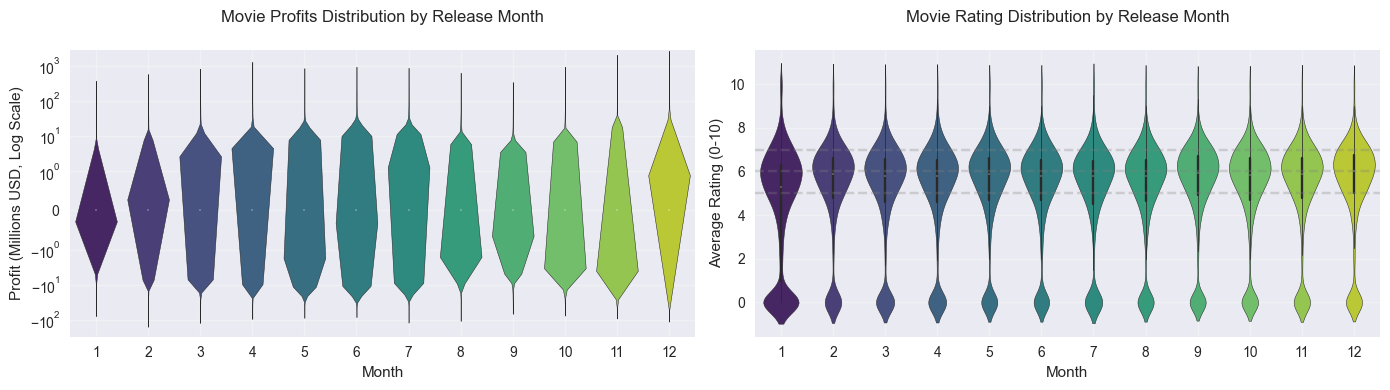

/Users/rizhong/Documents/GitHub/ada-2024-project-adaventurers2024/src/scripts/timing_analysis.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df[df['roi_clean'].notna()],


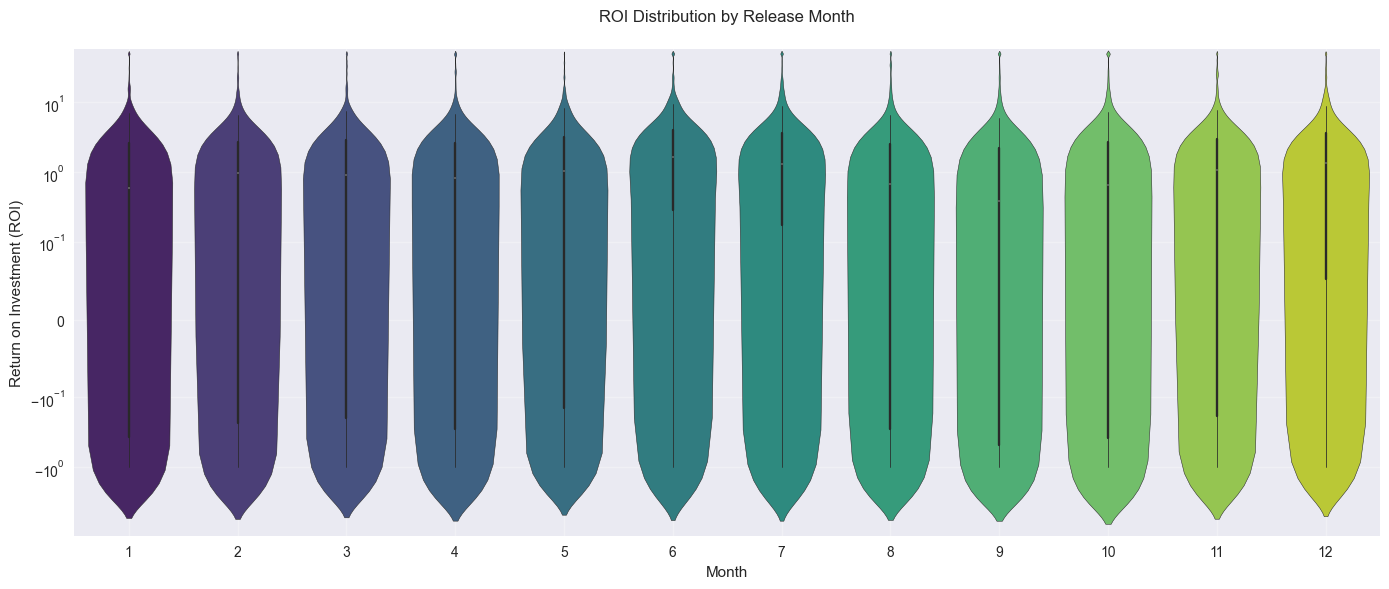

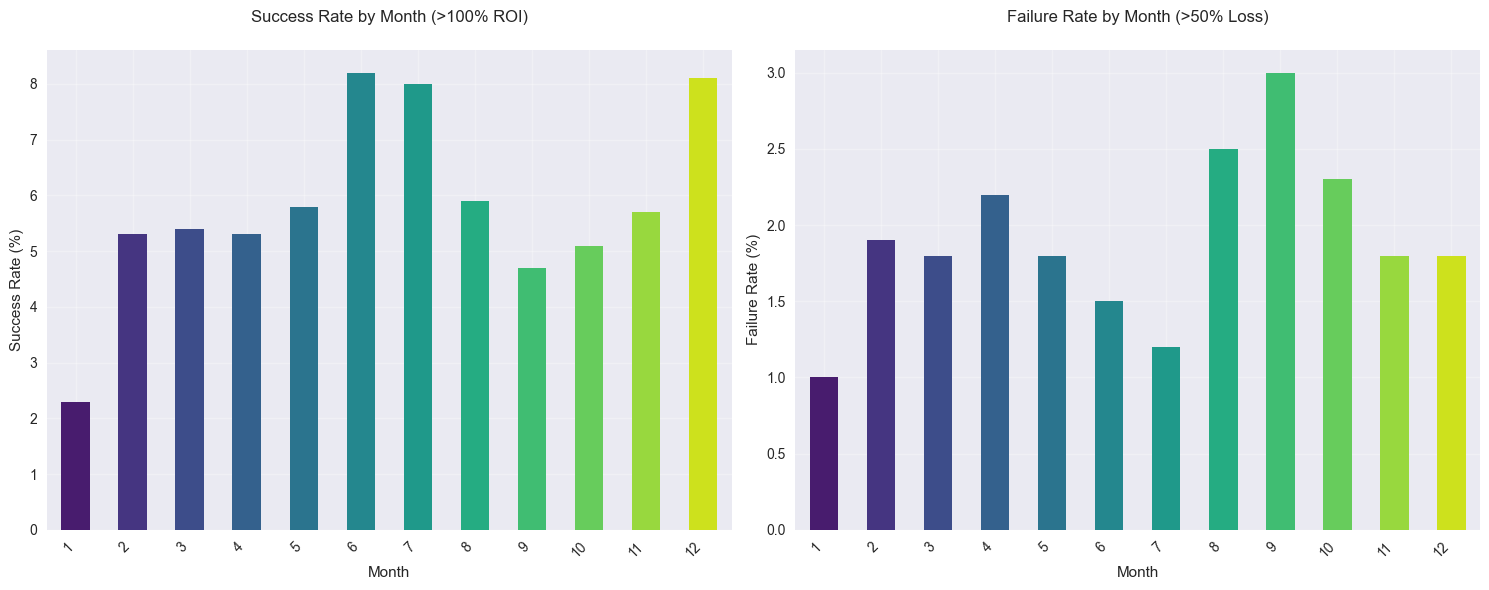

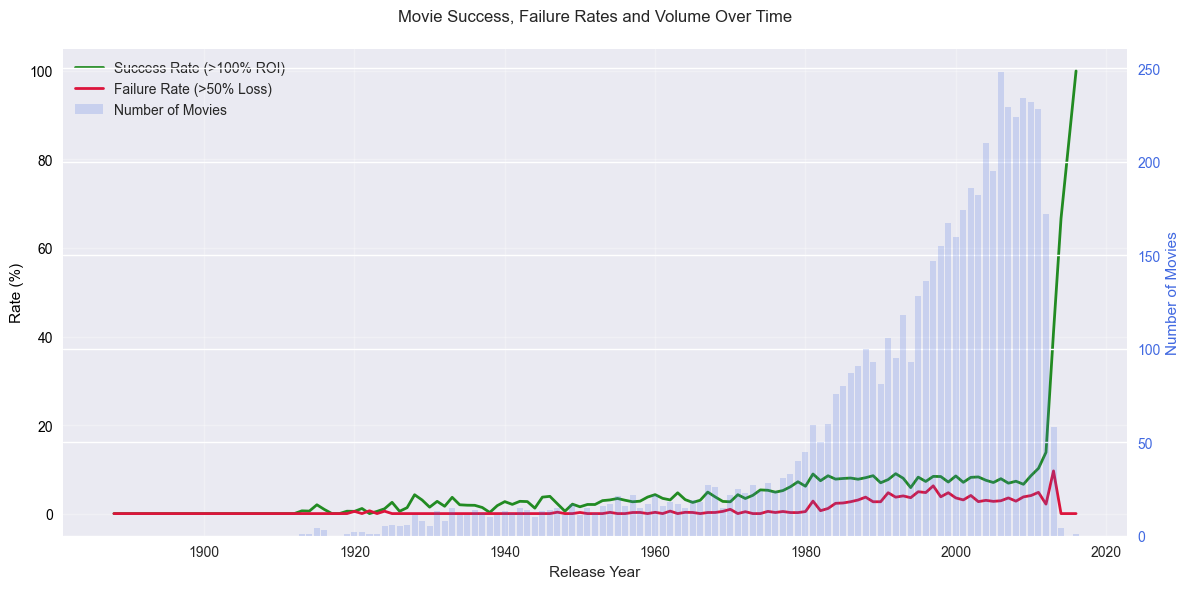

In [2]:
from src.scripts.timing_analysis import *

# Seasonal Analysis
seasonal_stats = plot_seasonal_distributions(df)

# Monthly Analysis
analyze_monthly_performance(df)

# Monthly ROI Analysis
monthly_perf_df = analyze_monthly_roi(df)

# Monthly Success Rate Analysis
plot_monthly_success_rates(monthly_perf_df)

# Monthly Statistics
monthly_stats = analyze_monthly_statistics(df, monthly_perf_df)

# Yearly Analysis
yearly_performance = analyze_temporal_trends(df)

##### Seasonal Patterns

1. Profitability and ROI:

   - Fall shows best overall performance (high ROI: 3.46, good profit distribution)
   - Spring has highest mean profit (7.23M USD) and median ROI (1.16)
   - Winter consistently underperforms (lowest profit: 2.56M USD, lowest ROI: 2.77)
   - Summer shows moderate, stable performance

2. Ratings and Volume:

   - Ratings remain relatively consistent across seasons (range: 4.72-5.19)
   - Winter/Fall have highest release volumes (~13,000 movies each)
   - Spring/Summer have fewer releases (~11,500 movies each)

##### Monthly Patterns

1. Strong Months:

   - June/July: Highest success rates (~8%), good ROI potential
   - December: Strong performance (high success rate, good profit potential)
   - Summer months generally show better profit concentration

2. Weak Months:

   - January: Lowest success rate (~2%), volatile ROI
   - August/September: Highest failure rates (~3%)
   - Early fall months show increased risk

##### Historical Trends

- Movie volume increased significantly since 1980s
- Success/failure rates remained relatively stable until recent years
- Post-2000 shows increased volatility
- Possible data anomaly showing success spike near 2020

##### Key Takeaway

Best release windows appear to be summer months (June/July) and December, while January and early fall carry higher risks. Fall and Spring show strongest overall financial metrics, but Winter consistently underperforms across all measures.


<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>📖 Narrative & Thematic Elements</strong> 
</div>

A trope is a commonly recurring store-telling device in creative works. In film, tropes can be anything from narrative patterns (like the "last-minute rescue") to character archetypes (like the "mad scientist"), or even specific plot devices (like "time-traveling mishaps"). While tropes aren't inherently good or bad, their execution and context largely determine their effectiveness in storytelling.

This analysis examines tropes that appear disproportionately often in poorly-rated films.

#### 6. Which tropes consistently lead to negative reception by genre?

In [ ]:
for movie_genre in ["Horror", "Adventure", "Comedy"]:
    vote_threshold = 6

    df_genre_tropes = df_cmu_tropes[df_cmu_tropes["genres_y"].str.contains(movie_genre)]
    df_genre_tropes = df_genre_tropes[df_genre_tropes["vote_count"] > 100]

    print(
        f"There are {len(df_genre_tropes.id.unique())} {movie_genre.lower()} films in the dataset"
    )

    df_low_rated_tropes = df_genre_tropes[
        df_genre_tropes["vote_average"] <= vote_threshold
    ]
    df_high_rated_tropes = df_genre_tropes[
        df_genre_tropes["vote_average"] > vote_threshold
    ]

    print(f"Films with low ratings: {len(df_low_rated_tropes.id.unique())}")
    print(f"Films with high ratings: {len(df_high_rated_tropes.id.unique())}")

    low_rated_tropes = df_low_rated_tropes.trope.value_counts()
    high_rated_tropes = df_high_rated_tropes.trope.value_counts()

    low_rated_dict = low_rated_tropes.to_dict()
    high_rated_dict = high_rated_tropes.to_dict()

    trope_ratios = {}
    for trope in low_rated_dict:
        low_count = low_rated_dict[trope]
        high_count = high_rated_dict.get(trope, 0)

        if low_count >= 5:
            ratio = low_count / (high_count + 1)
            trope_ratios[trope] = ratio

    sorted_tropes = sorted(trope_ratios.items(), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=[x[1] for x in sorted_tropes[:10]],
        y=[x[0] for x in sorted_tropes[:10]],
        palette="viridis",
    )
    plt.title(f"Top 10 tropes more common in low-rated {movie_genre.lower()} films")
    plt.xlabel("Ratio low:high rated")
    plt.ylabel("Tropes")
    plt.show()

The plot shows the top 10 narrative tropes that appear disproportionately more often in low-rated films compared to high-rated ones. The y-axis lists the tropes, while the x-axis shows the ratio of appearance in low-rated vs. high-rated films. We analyze for this initial results only 3 genres: horror, adventure and comedy.

Key observations for horror films:
- "BadSanta" and "JackassGenie" tropes have the highest ratios (approximately 9-10x), suggesting these supernatural antagonist concepts rarely work well in horror films
- Mid-tier ratios (6-7x) include concepts like "AttackOfTheTownFestival" and "SelfPlagiarism", indicating that festival-horror settings and derivative storytelling tend to correlate with lower ratings

Key observations for adventure films:
- "NotScreenedForCritics" tops the list (about 7.5x ratio), appearing in both comedy and adventure genres' low-rated films, suggesting it's a reliable indicator of lower quality across genres
- Superhero-related tropes ("Superman" and "TeenSuperspy" at ~6x and 5x respectively) indicate that certain superhero elements may be challenging to execute well in adventure films

Key observation for comedy films:
- "ContinuityReboot" has the highest ratio (around 9.5x), suggesting that comedy reboots of existing properties tend to be challenging to execute well
- Meta-industry tropes like "NotScreenedForCritics" and "SlasherFilm" (both ~5.5x) hint that comedies avoiding critical review or parodying horror often receive poor ratings
- Plot devices like "FakinMacGuffin" and "LastRequest" (both ~8x) appear to be overused in lower quality comedies
- Character-based tropes such as "TeenSuperspy" and "LiteralSplitPersonality" (both ~5x) show that certain character archetypes may be harder to execute successfully

#### 7. What recurring plot patterns appear most frequently in critically panned films?

In [ ]:
# Setting the style of the plots
sns.set_style("whitegrid", {"axes.grid": False})
plt.style.use("seaborn-v0_8-pastel")

# Load the data
df_cmu_tmdb = pd.read_csv("data/cmu_tmdb.csv")
df_movie_tropes = pd.read_csv("data/movie_tropes.csv")
df_movie_tropes = df_movie_tropes[["imdb_id", "trope_id", "trope", "description"]]

# Filtering data with 0 votes
df_cmu_tmdb = df_cmu_tmdb[
    (df_cmu_tmdb[["vote_average", "vote_count", "revenue"]] != 0).all(axis=1)
]
df_cmu_tmdb.reset_index(drop=True, inplace=True)
print("Number of movies before filtering: ", df_cmu_tmdb.shape[0])

# Filter movies with an average score lower than the threshold
THRESHOLD = 6
df_cmu_lr_movies = df_cmu_tmdb[df_cmu_tmdb["vote_average"] <= THRESHOLD]
df_cmu_lr_movies.reset_index(drop=True, inplace=True)
print("Number of movies with low rating: ", df_cmu_lr_movies.shape[0])

# Merge selected movies with tropes
df_cmu_tropes = pd.merge(df_cmu_lr_movies, df_movie_tropes, on="imdb_id", how="inner")
df_cmu_tropes.drop_duplicates(inplace=True)

print("Vote average statistics:")
print(df_cmu_tropes["vote_average"].describe())

# Get the top k tropes for low rated movies
K = 30
df_top_tropes_lr_movies = df_cmu_tropes["trope"].value_counts().reset_index().head(K)
df_top_tropes_lr_movies.columns = ["trope", "count"]

plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_tropes_lr_movies, x="count", y="trope", hue="trope", dodge=False
)
plt.title(f"Top {K} tropes in movies with a vote average of {THRESHOLD} or lower")
plt.ylabel("Tropes")
plt.xlabel("Number of movies")
plt.show()